<a href="https://colab.research.google.com/github/Sagar610/CE888/blob/main/Lab4/My_Recommender_quizz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import packages/libraries**

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Load the data files**

In [61]:
data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)

In [ ]:
test_data=pd.DataFrame(data)
test_data=pd.concat([test_data.loc[:, 0], test_data.loc[:, 1:].replace(99.00, np.NaN)], axis=1)
test_data.drop(columns=[0], inplace=True)

In [ ]:
data=pd.concat([data.loc[:, 0], data.loc[:, 1:].replace(99.00, np.NaN)], axis=1)
data.drop(columns=[0], inplace=True)

In [ ]:
val_data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
val_data.drop(columns=[0], inplace=True)
# val_data.head()

**Highest and lowest rated joke**

In [ ]:
print('Joke with highest rating : ', test_data.max(axis=0).idxmax())
print('Joke with lowest rating : ', test_data.min(axis=0).idxmin())

Joke with highest rating :  45
Joke with lowest rating :  1


In [ ]:
# val_data=pd.DataFrame(data)
# val_data.drop(columns=[0], inplace=True)

**Prepare Validation Data**

In [ ]:
arr = val_data.values
arr.shape

(24983, 100)

In [ ]:
rated = np.where(arr!=99)
print(len(rated[0]), rated[1].shape)

1810455 (1810455,)


In [ ]:
# data.drop(columns=[0], inplace=True)

In [ ]:
len(np.where(arr!=99)[1])

1810455

In [ ]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(arr!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [ ]:
new_arr, idx = replace(arr, 0.1)

In [ ]:
arr[idx[0][0], idx[1][0]]

-4.03

In [ ]:
new_arr[idx[0][0], idx[1][0]]

99.0

In [ ]:
val_data=pd.DataFrame(new_arr)
val_data=pd.DataFrame(val_data.loc[:, 0:].replace(99.00, np.NaN))
val_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,NaN,4.17,-8.98,-4.76,-8.50,NaN,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,NaN,-9.37,1.50,-4.37,NaN,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,NaN,NaN,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,NaN,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.08,-0.29,6.36,NaN,-2.38,NaN,-0.73,-5.34,8.88,9.22,NaN,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,NaN,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,NaN,...,NaN,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,NaN,3.93,NaN,4.85,6.07,NaN,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,NaN,7.33,NaN,6.17,9.08,NaN,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,NaN,8.16,NaN,6.21,NaN,1.84,7.33,6.60,6.31,8.11,NaN,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,NaN,3.93,6.75,6.60,NaN,6.65,NaN,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,NaN,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,NaN,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,NaN,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,NaN,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,NaN,1.60


**Training**

In [ ]:
n_latent_factors = 2

user_ratings = data.values
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [67]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 2) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [19]:
num_iter = 10
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations

Iteration 0/10:	MSE=26.126720
Iteration 2/10:	MSE=24.919272
Iteration 4/10:	MSE=24.450319
Iteration 6/10:	MSE=23.976154
Iteration 8/10:	MSE=23.499200


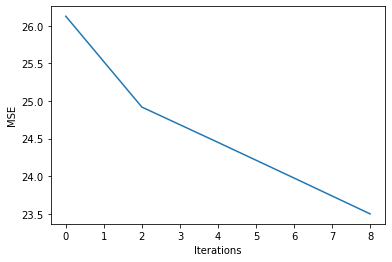

In [20]:
plt.figure()
plt.plot(np.arange(0, num_iter, 2), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

**Predicting**

In [69]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[1.01665971, 0.69850008, 0.71123099, ..., 1.37560862, 0.42372363,
        1.77389137],
       [0.86306795, 0.56017778, 0.55609125, ..., 1.01545276, 0.42523041,
        1.33906635],
       [1.39138077, 0.89288941, 0.88167282, ..., 1.58970488, 0.70588971,
        2.10690756],
       ...,
       [0.88644669, 0.58443078, 0.58435663, ..., 1.0851299 , 0.41861115,
        1.42152312],
       [1.35139713, 0.90953731, 0.91785605, ..., 1.74053129, 0.60108476,
        2.26157411],
       [1.85987505, 1.22125493, 1.21884989, ..., 2.25372956, 0.88819378,
        2.95733451]])

**Predicting on Validation set**

In [68]:
val_data=pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)
val_data.drop(columns=[0], inplace=True)
val_data=pd.DataFrame(val_data.loc[:, 0:].replace(99.00, np.NaN))

v_data=pd.DataFrame(new_arr)
v_data=pd.DataFrame(v_data.loc[:, 0:].replace(99.00, np.NaN))

v_user_ratings=v_data.values

v_values = [zip(v_user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
v_comparison_data = pd.DataFrame(v_values)
v_comparison_data.columns = data.columns

# v_comparison_data

ValueError: ignored

In [23]:
val_user_ratings=val_data.values

error = []

for user_id in range(latent_user_preferences.shape[0]):
    for item_id in range(latent_item_features.shape[0]):
        rating = val_user_ratings[user_id, item_id]
        
        if not np.isnan(rating):
             val_predicted_rating = predict_rating(user_id, item_id)
             err =  val_predicted_rating - rating
             
            #  err = train(user_id, item_id, rating)
             error.append(err)
val_mse = (np.array(error) ** 2).mean()
print('MSE on Validation Set :', val_mse)

MSE on Validation Set : 23.133871466582754


**Predicting on Test Set**

In [24]:
test_user_ratings=test_data.values
values = [zip(test_user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = data.columns
comparison_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,"(-7.82, 1.0166597061200338)","(8.79, 0.6985000804520969)","(-9.66, 0.7112309868990819)","(-8.16, -0.6298167458489917)","(-7.52, 0.650890755138105)","(-8.5, 2.0030568343577144)","(-9.85, 0.08388621232001627)","(4.17, -0.3955889737424009)","(-8.98, -0.169033011321544)","(-4.76, 1.412024918748699)","(-8.5, 1.962679664149643)","(-6.75, 1.9668939691960057)","(-7.18, -1.2338321424237195)","(8.45, 1.9411444225686065)","(-7.18, -1.3150840888796729)","(-7.52, -2.469607367014773)","(-7.43, -0.6098536577038237)","(-9.81, -0.272127306442474)","(-9.85, 0.5511638887041375)","(-9.85, -0.36368688472715405)","(-9.37, 2.3848402474646884)","(1.5, 1.2396753428851048)","(-4.37, 0.5806505587627111)","(-9.81, -0.9467634231688206)","(-8.5, 0.9226571525169163)","(1.12, 1.8606647672778547)","(7.82, 3.1347639247619328)","(2.86, 1.8663124517117495)","(9.13, 3.0700544886196135)","(-7.43, 0.19574501171456915)","(2.14, 2.3978354992384414)","(-4.08, 3.1802963830953557)","(-9.08, -0.6755849604280753)","(7.82, 1.4672108966363706)","(5.05, 3.092573356824171)","(4.95, 3.224375114485199)","(-9.17, -0.8481076588253215)","(-8.4, 1.5526060462754123)","(-8.4, 1.5916007374564867)","(-8.4, 1.5281870843346925)",...,"(8.59, 2.722000764466875)","(3.59, 3.0142610098792804)","(-6.84, 0.7620174937852842)","(-9.03, -0.14718801038148432)","(2.82, 2.4866247129979278)","(-1.36, 2.7402659080255543)","(-9.08, -0.28540036765020627)","(8.3, 2.830927353535528)","(5.68, 2.893335568212649)","(-4.81, 0.9604412997946663)","(nan, -0.030192345292775116)","(nan, 2.733289411025657)","(nan, 1.5810456730934008)","(nan, -0.6924407824668226)","(nan, 0.43030387117720115)","(nan, 2.5533107701122564)","(nan, 1.1988652870923107)","(-9.42, 1.9905613349628568)","(nan, 0.9622204842060521)","(nan, 1.7383230610956393)","(nan, 2.156145992356383)","(-7.72, 1.3530829315306425)","(nan, 2.33121171939228)","(nan, 1.2603715642793853)","(nan, 1.4084066581132888)","(nan, 0.7349365117010127)","(nan, 2.1486569164750113)","(nan, 2.178611101599527)","(nan, 3.34639358465598)","(nan, 1.0821998330140412)","(2.82, 2.094068062201177)","(nan, 1.4743109372931134)","(nan, 2.573997219509405)","(nan, 1.417587276496191)","(nan, 1.275294951130727)","(nan, 1.721397472395011)","(-5.63, 1.8248659630672954)","(nan, 1.3756086247696444)","(nan, 0.4237236301468294)","(nan, 1.773891366523853)"
1,"(4.08, 0.863067950750945)","(-0.29, 0.5601777821336898)","(6.36, 0.5560912477956031)","(4.37, -0.47118448032607857)","(-2.38, 0.573352445786379)","(-9.66, 1.4626641643971616)","(-0.73, 0.020220068478483653)","(-5.34, -0.23817778897768646)","(8.88, -0.019551923265585802)","(9.22, 1.0734261283400897)","(6.75, 1.5591107429762308)","(8.64, 1.454909370988665)","(4.42, -0.9223712811776795)","(7.43, 1.4320575865839735)","(4.56, -0.9762651363761318)","(-0.97, -1.8159473826613974)","(4.66, -0.42806164577128497)","(-0.68, -0.20851521283330265)","(3.3, 0.41998716004414455)","(-1.21, -0.2383159499880503)","(0.87, 1.8393820912595291)","(8.64, 0.9962673444778122)","(8.35, 0.4595549470124783)","(9.17, -0.7218221544184923)","(0.05, 0.7248285073259031)","(7.57, 1.3387224774259199)","(4.71, 2.3976925120499266)","(0.87, 1.413264634401153)","(-0.39, 2.269857043053798)","(6.99, 0.18938694086975413)","(6.5, 1.8682750276637836)","(-0.92, 2.384532790205035)","(7.14, -0.41779026445877415)","(9.03, 1.085563799785975)","(-1.8, 2.3245132589904856)","(0.73, 2.420589174281862)","(7.09, -0.5294313163517486)","(3.4, 1.17813441527202)","(-0.87, 1.2046272228463835)","(7.91, 1.1189499362367854)",...,"(-6.7, 2.034861205304736)","(-3.35, 2.2895709793226255)","(-9.03, 0.6191593052690936)","(4.47, -0.06763559144648831)","(4.08, 1.9345812168785494)","(-3.83, 2.045217695930833)","(8.74, -0.161946106426592)","(1.12, 2.0779454128262964)","(0.78, 2.101

In [25]:
# while 1: pass

# For Quiz

In [62]:
quiz_users = pd.read_excel("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx",sheet_name='Users')
quiz_items = pd.read_excel("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx",sheet_name='Items')

In [27]:
#quiz_movies

In [63]:
test_data.loc[1458 , 17]

-4.22

In [66]:
comparison_data.loc[2092, 12]

(8.83, 2.858489693038405)

In [70]:
comparison_data.loc[525, 422]

KeyError: ignored

In [31]:
quiz_users.loc[quiz_users['User']==4327, 'Factor14']

21   -0.09349
Name: Factor14, dtype: float64

In [32]:
round(-0.09349, 3)

-0.093

In [64]:
quiz_items.loc[quiz_items['Movie ID']==38, 'Factor2']

6    1.771799
Name: Factor2, dtype: float64

In [65]:
(quiz_items.loc[quiz_items['Factor7']==np.max(quiz_items['Factor7']), ['Movie ID', 'Factor7']])

,Movie ID,Factor7
90,8467,3.524783


In [35]:
quiz_items.head()

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


In [36]:
np.argmin(quiz_items.loc[:, 'Factor4'].values)

51

In [37]:
quiz_items.loc[51, ['Title', 'Factor4']]

Title      The Matrix Reloaded (2003)
Factor4                      -2.25595
Name: 51, dtype: object

In [38]:
a=quiz_items.loc[quiz_items['Movie ID']==604]

In [39]:
a=a.values.squeeze()

In [40]:
a=a[2:]
a

array([0.5034136375632308, -2.0044497136888157, 0.0010836504269544941,
       -2.255945306069563, 0.882547301517155, -0.1885996561673766,
       -0.23543435807103433, 0.5700275737617247, -3.492896705973438,
       -0.3122139148478878, 0.9027423941200303, -2.0633182362860927,
       -1.8951014444231724, 0.7484579000094597, 2.1209074375384924],
      dtype=object)

In [41]:
b=quiz_users.loc[quiz_users['User']==174]

In [42]:
b=b.values.squeeze()

In [43]:
b=b[1:]
b

array([-0.22746168, -0.27253193, -0.01723089,  0.05432418,  0.21475532,
       -0.07263876, -0.03312156, -0.08650818, -0.13147905,  0.18040285,
        0.09588959, -0.08239632,  0.03676717, -0.16543839,  0.05069195])

In [44]:
quiz_pred=np.dot(b, a.T)

In [45]:
round(quiz_pred, 2)

1.04

In [46]:
c=quiz_items.loc[quiz_items['Movie ID']==812]
c=c.values.squeeze()
c=c[2:]
c

array([0.9444072873203204, -0.17405053859224534, 0.12318628233184109,
       2.2243105344641236, -0.5695513857263874, 0.018065057433469225,
       0.3010679396871695, 0.03472533646290326, -0.20630092072921338,
       0.5333225541299694, -0.8823041399125704, -0.4469824426741521,
       1.3020155376267466, 0.8368295247444454, -0.46760653696757254],
      dtype=object)

In [47]:
quiz_pred=np.dot(b, c.T)
round(quiz_pred, 2)

-0.22

In [48]:
u_2067=quiz_users.loc[quiz_users['User']==4373]
u_2067=u_2067.values.squeeze()
u_2067=u_2067[1:]
u_2067

array([-0.1365496 , -0.08940568, -0.23539942,  0.12058533, -0.16816781,
        0.12998995, -0.03508359, -0.32402785,  0.08753111,  0.04528984,
        0.20784991, -0.02897165, -0.1751839 , -0.05828269,  0.14779738])

In [49]:
all_item_factors=quiz_items.values[:, 2:]

In [50]:
quiz_ratings=np.dot(u_2067, all_item_factors.T)

In [51]:
np.argmax(quiz_ratings)

50

In [52]:
np.argsort(quiz_ratings)[::-1][:2]

array([50, 11])

In [53]:
quiz_items.loc[np.argsort(quiz_ratings)[::-1][:3], :]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
50,603,The Matrix (1999),-3.063639,-1.319283,-0.043618,-0.994612,-0.954054,0.190838,0.197918,-0.093962,-1.082840,-0.003843,1.377453,-1.668189,-1.348377,0.223797,0.752413
11,105,Back to the Future (1985),-1.107666,-0.039506,0.109809,0.169149,-1.625467,1.673495,-0.544459,0.420603,1.184404,0.396530,1.240446,0.016825,-0.582166,-0.757412,0.118024
35,329,Jurassic Park (1993),-0.104238,-1.105404,-0.497630,0.459678,-1.146451,0.842279,0.224978,0.541354,1.570226,-0.633001,1.053255,-0.526942,0.082476,-0.005909,1.466918


In [54]:
u_4940=quiz_users.loc[quiz_users['User']==4373]
u_4940=u_4940.values.squeeze()
u_4940=u_4940[1:]
u_4940

array([-0.1365496 , -0.08940568, -0.23539942,  0.12058533, -0.16816781,
        0.12998995, -0.03508359, -0.32402785,  0.08753111,  0.04528984,
        0.20784991, -0.02897165, -0.1751839 , -0.05828269,  0.14779738])

In [55]:
quiz_ratings=np.dot(u_2067, all_item_factors.T)
np.argsort(quiz_ratings)[::-1][:2]

array([50, 11])

In [56]:
quiz_items.loc[np.argsort(quiz_ratings)[::-1][:2], :]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
50,603,The Matrix (1999),-3.063639,-1.319283,-0.043618,-0.994612,-0.954054,0.190838,0.197918,-0.093962,-1.082840,-0.003843,1.377453,-1.668189,-1.348377,0.223797,0.752413
11,105,Back to the Future (1985),-1.107666,-0.039506,0.109809,0.169149,-1.625467,1.673495,-0.544459,0.420603,1.184404,0.396530,1.240446,0.016825,-0.582166,-0.757412,0.118024


In [57]:
np.average(data.loc[:, 45].values[~np.isnan(data.loc[:, 45].values)])

1.1086161781946073